In [1]:
import numpy as np
import pywt
import subprocess
from sklearn.model_selection import KFold
import scipy.sparse as sp
wvt = 'db12'

In [2]:
%run -i "Snippets/common_functions_and_variables.py"

In [3]:
das_data = np.load("Data/filtdas.npy")

In [4]:
nodal_data = np.load("Data/nodal_rotated_data.npy")
nodal_data_x = nodal_data[0]
nodal_data_y = nodal_data[1]

In [5]:
best_offset = 17 # determined by fitting DAS reconstruction using all nodes to the DAS data

In [6]:
das_data = das_data[:, (150-best_offset) : (550-best_offset)]
nodal_data_x = nodal_data_x[:, 150:550]
nodal_data_y = nodal_data_y[:, 150:550]

In [7]:
das_stds = np.std(das_data, axis=1)
nodal_x_stds = np.std(nodal_data_x, axis=1)
nodal_y_stds = np.std(nodal_data_y, axis=1)

In [8]:
das_data = das_data / das_stds[:, np.newaxis]
nodal_data_x = nodal_data_x / nodal_x_stds[:, np.newaxis]
nodal_data_y = nodal_data_y / nodal_y_stds[:, np.newaxis]

In [9]:
das_wvt_data = np.array([np.hstack(pywt.wavedec(d, wvt)) for d in das_data])
nodal_wvt_data_x = np.array([np.hstack(pywt.wavedec(d, wvt)) for d in nodal_data_x])
nodal_wvt_data_y = np.array([np.hstack(pywt.wavedec(d, wvt)) for d in nodal_data_y])

In [10]:
wvt_tmp = pywt.wavedec(das_data[0], wvt)
wvt_lens = [len(wc) for wc in wvt_tmp]

In [11]:
Gn_das = 5.487292209780819e-06
Gn_nodes = 0.0003260777891832482

In [12]:
G_das = np.load("Data/G.npy")*Gn_das
G_nodes = np.load("Data/nodal_G.npy")*Gn_nodes

In [13]:
np.random.seed(94899109)
permute_idx = np.random.permutation(nodal_data_x.shape[0])
kf = KFold(n_splits=5)

Snippets/common_functions_and_variables.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  geo = ccrs.Geodetic()


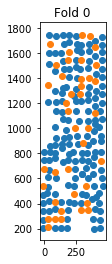

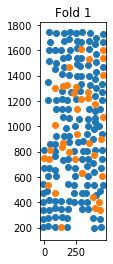

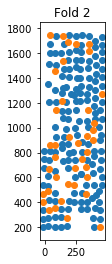

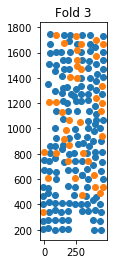

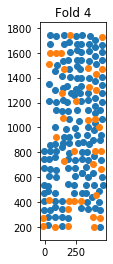

In [19]:
import matplotlib.pyplot as plt

proj_n_1 = np.load("tmp/proj_n_1.npy")
proj_n_2 = np.load("tmp/proj_n_2.npy")

for fold, (train, test) in enumerate(kf.split(permute_idx)):
    plt.figure()
    plt.scatter(proj_n_1[permute_idx[train]], proj_n_2[ permute_idx[train]])
    plt.scatter(proj_n_1[permute_idx[test]], proj_n_2[ permute_idx[test]])
    plt.title(f"Fold {fold}")
    plt.axes().set_aspect('equal')


In [14]:
# perform only node inversions

mse_results_nodes = np.zeros((5,5))

for fold, (train, test) in enumerate(kf.split(permute_idx)):
    for n_train in [1, 2, 3, 4, 5]:
        if n_train != 5:
            train_subset = permute_idx[train[:(n_train*(len(train)//5))]]
        else:
            train_subset  = permute_idx[train]
            
        G_nodes_train = G_nodes[train_subset]
        G_nodes_train_full = np.vstack([np.hstack([G_nodes_train/nodal_x_stds[train_subset][:, np.newaxis], np.zeros(G_nodes_train.shape)]),
                                  np.hstack([np.zeros(G_nodes_train.shape), G_nodes_train/nodal_y_stds[train_subset][:, np.newaxis]])])

        G_nodes_test= G_nodes[test]
        G_nodes_test_full = np.vstack([np.hstack([G_nodes_test/nodal_x_stds[test][:, np.newaxis], np.zeros(G_nodes_test.shape)]),
                                  np.hstack([np.zeros(G_nodes_test.shape), G_nodes_test/nodal_y_stds[test][:, np.newaxis]])])
        
        Gn_nodes_full = np.std(G_nodes_train_full)
        G_nodes_train_full = G_nodes_train_full / Gn_nodes_full 
        G_nodes_test_full = G_nodes_test_full / Gn_nodes_full
        nodal_wvt_data_train_full = np.vstack([nodal_wvt_data_x[train_subset],
                                         nodal_wvt_data_y[train_subset]])
        np.save("tmp/data.npy", nodal_wvt_data_train_full)
        np.save("tmp/G.npy",  G_nodes_train_full)
        subprocess.run(f"/Applications/Julia-1.4.app/Contents/Resources/julia/bin/julia combinedinversion.jl {fold}_{n_train}_nodes", shell=True, env={"JULIA_NUM_THREADS" : "12"})
        res = sp.load_npz(f"Combined_Results/combined_results_{fold}_{n_train}_nodes.npz")
        nodal_wvt_data_test_pred = G_nodes_test_full @ res
        nodal_data_test_pred = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in nodal_wvt_data_test_pred]))

        
        nodal_data_test_full = np.vstack([nodal_data_x[test],
                                              nodal_data_y[test]])
        
        mse = np.mean(np.square(nodal_data_test_full - nodal_data_test_pred))
        print(f"Fold {fold}, percent_train {20*n_train}, mse = {mse}")
        mse_results_nodes[n_train-1, fold] = mse

Fold 0, percent_train 20, mse = 0.8627582230469198


KeyboardInterrupt: 

In [80]:
np.save("Combined_Results/node_mse.npy", mse_results_nodes)

In [15]:

mse_results_nodes_das = np.zeros((5,5))

for fold, (train, test) in enumerate(kf.split(permute_idx)):
    for n_train in [1, 2, 3, 4, 5]:
        #This part is the same as before
        if n_train != 5:
            train_subset = permute_idx[train[:(n_train*(len(train)//5))]]
        else:
            train_subset  = permute_idx[train]
            
        G_nodes_train = G_nodes[train_subset]
        G_nodes_train_full = np.vstack([np.hstack([G_nodes_train/nodal_x_stds[train_subset][:, np.newaxis], np.zeros(G_nodes_train.shape)]),
                                  np.hstack([np.zeros(G_nodes_train.shape), G_nodes_train/nodal_y_stds[train_subset][:, np.newaxis]])])

        G_nodes_test= G_nodes[test]
        G_nodes_test_full = np.vstack([np.hstack([G_nodes_test/nodal_x_stds[test][:, np.newaxis], np.zeros(G_nodes_test.shape)]),
                                  np.hstack([np.zeros(G_nodes_test.shape), G_nodes_test/nodal_y_stds[test][:, np.newaxis]])])
        
        nodal_wvt_data_train_full = np.vstack([nodal_wvt_data_x[train_subset],
                                         nodal_wvt_data_y[train_subset]])
        
        
        
        #Now we add DAS as well
        G_das_train = G_das/das_stds[:, np.newaxis]
        wvt_data_train_full = np.vstack([nodal_wvt_data_train_full, 
                                         das_wvt_data])
        
        G_train_full = np.vstack([G_nodes_train_full, 
                                  G_das_train])

        Gn_train_full = np.std(G_train_full)
        G_train_full = G_train_full / Gn_train_full 
        G_nodes_test_full = G_nodes_test_full / Gn_train_full

        np.save("tmp/data.npy", wvt_data_train_full)
        np.save("tmp/G.npy",  G_train_full)
        
        #And then the rest is the same again
        subprocess.run(f"/Applications/Julia-1.4.app/Contents/Resources/julia/bin/julia combinedinversion.jl {fold}_{n_train}_nodes_das", shell=True, env={"JULIA_NUM_THREADS" : "12"})
        res = sp.load_npz(f"Combined_Results/combined_results_{fold}_{n_train}_nodes_das.npz")
        nodal_wvt_data_test_pred = G_nodes_test_full @ res
        nodal_data_test_pred = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in nodal_wvt_data_test_pred]))

        
        nodal_data_test_full = np.vstack([nodal_data_x[test],
                                              nodal_data_y[test]])
        
        mse = np.mean(np.square(nodal_data_test_full - nodal_data_test_pred))
        print(f"Fold {fold}, percent_train {20*n_train}, mse = {mse}")
        mse_results_nodes_das[n_train-1, fold] = mse

KeyboardInterrupt: 

In [ ]:
np.save("Combined_Results/node_das_mse.npy", mse_results_nodes_das)

In [14]:
# Das by itself


G_nodes_test= G_nodes
G_nodes_test_full = np.vstack([np.hstack([G_nodes_test/nodal_x_stds[:, np.newaxis], np.zeros(G_nodes_test.shape)]),
                          np.hstack([np.zeros(G_nodes_test.shape), G_nodes_test/nodal_y_stds[:, np.newaxis]])])

G_das_train = G_das/das_stds[:, np.newaxis]
wvt_data_train_full = das_wvt_data

G_train_full = G_das_train

Gn_train_full = np.std(G_train_full)
G_train_full = G_train_full / Gn_train_full 
G_nodes_test_full = G_nodes_test_full / Gn_train_full

np.save("tmp/data.npy", wvt_data_train_full)
np.save("tmp/G.npy",  G_train_full)

#And then the rest is the same again
#subprocess.run(f"/Applications/Julia-1.4.app/Contents/Resources/julia/bin/julia combinedinversion.jl das_only", shell=True, env={"JULIA_NUM_THREADS" : "6"})
res = sp.load_npz(f"Combined_Results/combined_results_das_only.npz")
nodal_wvt_data_test_pred = G_nodes_test_full @ res
nodal_data_test_pred = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in nodal_wvt_data_test_pred]))

In [16]:
nodal_data_test_full = np.vstack([nodal_data_x,
                                      nodal_data_y])

for fold, (train, test) in enumerate(kf.split(permute_idx)):
    mse = np.mean(np.square(nodal_data_test_full[test] - nodal_data_test_pred[test]))
    print(f"DAS Only, fold {fold} mse = {mse}")

DAS Only, fold 0 mse = 0.9053915708650694
DAS Only, fold 1 mse = 0.8779530299761403
DAS Only, fold 2 mse = 1.2352462893894691
DAS Only, fold 3 mse = 0.6940985229834654
DAS Only, fold 4 mse = 0.6334294686558409
